## A intenção do projeto é criar um chatbot baseado em reviews de filmes para que se possa fazer perguntas e manter uma conversa livre

- link do banco de dados https://www.kaggle.com/Cornell-University/movie-dialog-corpus?select=movie_lines.tsv
- referências
>- https://shanebarker.com/blog/deep-learning-chatbot/
> -https://towardsdatascience.com/how-to-create-a-chatbot-with-python-deep-learning-in-less-than-an-hour-56a063bdfc44

In [1]:
!pip3 install gensim
!pip3 install tensorflow
!pip3 install keras

In [1]:
import pandas as pd
import re
import gensim
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from keras.models import Sequential
from scipy.spatial import distance

### Opening movie reviews

In [37]:
messages = pd.read_csv('./chatdata/movie_lines.tsv', header = None, delimiter="\t", quoting=3, encoding='ISO-8859-2')

In [38]:
messages.columns = ['msg_line', 'user_id', 'movie_id', 'user_name', 'msg']

In [39]:
messages.head(10)

,msg_line,user_id,movie_id,user_name,msg
0,L1045,u0,m0,BIANCA,They do not!
1,L1044,u2,m0,CAMERON,They do to!
2,L985,u0,m0,BIANCA,I hope so.
3,L984,u2,m0,CAMERON,She okay?
4,L925,u0,m0,BIANCA,Let's go.
5,L924,u2,m0,CAMERON,Wow
6,L872,u0,m0,BIANCA,Okay -- you're gonna need to learn how to lie.
7,L871,u2,m0,CAMERON,No
8,"""L870",u0,m0,BIANCA,I'm kidding. You know how sometimes you just ...
9,L869,u0,m0,BIANCA,Like my fear of wearing pastels?


### Data exploration

In [5]:
#setting parameters for data visualization
np.set_printoptions(threshold=None, precision=2)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('precision', 2)

#### Data Analysis based on this article
- https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools?utm_source=medium&utm_medium=crosspost&utm_campaign=blog-exploratory-data-analysis-natural-language-processing-tools

In [20]:
!pip3 install \
   pandas matplotlib numpy \
   nltk seaborn sklearn gensim pyldavis \
   wordcloud textblob spacy textstat

     |████████████████████████████████| 283 kB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 770 kB/s eta 0:00:01
     |████████████████████████████████| 372 kB 760 kB/s eta 0:00:01
     |████████████████████████████████| 102 kB 1.1 MB/s ta 0:00:01
     |████████████████████████████████| 829 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 164 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 272 kB 1.0 MB/s eta 0:00:01     |███████████████████████████████▎| 266 kB 1.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.9 MB 307 kB/s eta 0:00:01
     |████████████████████████████████| 99 kB 138 kB/s eta 0:00:01     |██████▋                         | 20 kB 1.3 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=eb98d033320aa298d65cbc3d45ca4bf2effbff7824eea19bad49d2897846cdfc
  Stored in directory: /home/douglas/.cache/pip/wheels/22/0b/40/fd3f795caaa1fb4c6cb738bc1f56100be1e57da9

In [40]:
data = messages['user_name']

In [41]:
len(data)

304713

In [42]:
data.describe()

count     304670
unique      5929
top         JACK
freq        3032
Name: user_name, dtype: object

### Number of characters of each message

<AxesSubplot:>

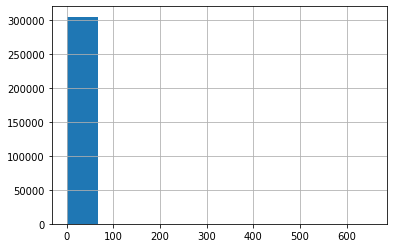

In [43]:
#histogram to display the number of character of each message
data.str.len().hist()

The number of characters are between 0 and 500

### Removing non-alphabetical messages

In [44]:
#there are some non-alphabetical messages that need to be found
data.loc[data.isna()].size

#the above statment does the same of this
#msg.loc[msg.isnull()].size

43

In [537]:
#filling the nan messages with a string
#messages = messages.fillna('.')

### Number of words for each message

<AxesSubplot:>

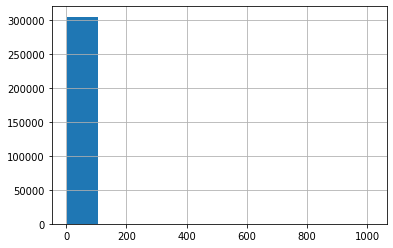

In [45]:
#number of words for each message
data.str.split(' ').\
    map(lambda x: len(str(x))).\
    hist()

The number of words are between 0 and 100

### Average word length

In [16]:
#checking the average word length
data.str.split(' ').\
   apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x)).hist()

TypeError: 'float' object is not iterable

The length of words goes from 0 to 15

The word 'I' has the biggest occurrence. There are a lot of messages like dashes that can be removed

## Value types

In [46]:
#checking the average word length
data_set = [type(item) for item in data]
data_set = set(data_set)
data_set

{float, str}

## Print float values

In [47]:
[it for it in data if isinstance(it, float)]

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

## Print user_id of nan user_names

In [50]:
messages[messages['user_name'].isna()]

,msg_line,user_id,movie_id,user_name,msg
129360,L50228,u3764,m248 215 CONTINUED:,NaN,NaN
129361,L50147,u3764,m248 175 CONTINUED:,NaN,NaN
129363,L50054,u3764,m248 150 CONTINUED:,NaN,NaN
129365,L50011,u3764,m248 139 CONTINUED:,NaN,NaN
129367,L50007,u3764,m248 134 CONTINUED:,NaN,NaN
129370,L49991,u3764,m248 134 CONTINUED:,NaN,NaN
129372,L49950,u3764,m248 117 CONTINUED:,NaN,NaN
129373,L49895,u3764,m248 107 CONTINUED:,NaN,NaN
129376,L49864,u3764,m248 102 CONTINUED:,NaN,NaN
129377,L49826,u3764,m248 89 CONTINUED:,NaN,NaN


## Print long user_names

In [65]:
set([n for n in data if not(str(n).isupper())])

{"A.T.L I'm not sure.  We have no launch protocol; the entry of the passenger is supposed to initiate activation.",
 "A.T.L There is no abort procedure -- we don't know how we turned the damn thing on let alone how to turn it off.",
 "A.T.L There's no plug to pull.",
 'A.T.L We have benzel activation repeat we have benzel activation.  Control to Arroway you okay in there?  Repeat Control to Arroway come back.',
 "A.T.L We've lost contact.",
 "BUSTER You're* a doctor Homer--you don't smell like ether.",
 'C.O ""We\'ll all have lunch.""  Good idea. Oh and let\'s be sure to invite this sociologist too -- just in case we want to have a FUCKING BRIDGE GAME AFTERWARDS!"',
 "C.O -- nothing I can do about it unless you're suggesting I infringe on their civil liberties -- which I'd happily do if you'll just trim a little fat off the Constitution.",
 "C.O All right lieutenant give me a name and specifics I'll have the X.O. file an action first thing in the morning.  A name?",
 "C.O And if you ju